Let's continue the EDA, build and select a suitable regression model in this notebook..

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

#!pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot, prediction_error, residuals_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading data 
df = pd.read_csv(r'C:\Users\nesha\Desktop\car_cleaned_data.csv', index_col=0)
print(df.shape)
df.head()

(8819, 19)


,Name,Mileage,Address,Rating,Fuel Type,City MPG,Highway MPG,Drivetrain,Engine,Exterior Color,Interior Color,Transmission,Entertainment Count,Safety Count,Price,Built Year,Make,Model,Zipcode
0,2018 Volvo V60 T5 Dynamic,37386,"Portland, OR 97214",4.9,Gasoline,25.0,36.0,FWD,2.0L,Black,Unknown,Automatic,2.0,3.0,25800,2018,Volvo,V60,97214
1,2019 Audi A5 2.0T Premium,22028,"Portland, OR 97201",4.8,Gasoline,23.0,34.0,AWD,2.0L,White,Black,Automatic,3.0,4.0,38788,2019,Audi,A5,97201
2,2009 Volkswagen New Beetle 2.5,86721,"Portland, OR 97232",4.9,Gasoline,20.0,29.0,FWD,2.5L,White,Black,Automatic,2.0,2.0,8599,2009,Volkswagen,Other,97232
3,2018 Toyota Camry XLE,11936,"Portland, OR 97209",3.6,Gasoline,28.0,39.0,FWD,Regular,Black,Unknown,Automatic,2.0,5.0,25799,2018,Toyota,Camry,97209
4,2018 Lexus GX 460 Base,33065,"Portland, OR 97239",4.3,Gasoline,15.0,18.0,4WD,4.6L,Gray,Brown,Automatic,2.0,3.0,39990,2018,Lexus,GX,97239


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8819 entries, 0 to 10014
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 8819 non-null   object 
 1   Mileage              8819 non-null   int64  
 2   Address              8819 non-null   object 
 3   Rating               8819 non-null   float64
 4   Fuel Type            8819 non-null   object 
 5   City MPG             8819 non-null   float64
 6   Highway MPG          8819 non-null   float64
 7   Drivetrain           8819 non-null   object 
 8   Engine               8810 non-null   object 
 9   Exterior Color       8819 non-null   object 
 10  Interior Color       8819 non-null   object 
 11  Transmission         8819 non-null   object 
 12  Entertainment Count  8819 non-null   float64
 13  Safety Count         8819 non-null   float64
 14  Price                8819 non-null   int64  
 15  Built Year           8819 non-null   

Since we have parsed the information we wanted from Name and Address we can now drop these columns:

In [4]:
#droping Name and Address
df.drop(columns = ['Name', 'Address'], inplace = True)
df.shape

(8819, 17)

For now let's dip deep into our numeric features:

In [5]:
numeric_features = ['Built Year', 'Mileage', 'Rating', 'City MPG', 'Highway MPG',
                    'Entertainment Count', 'Safety Count', 'Price']
num_df = df.loc[:,numeric_features]
num_df.head()

,Built Year,Mileage,Rating,City MPG,Highway MPG,Entertainment Count,Safety Count,Price
0,2018,37386,4.9,25.0,36.0,2.0,3.0,25800
1,2019,22028,4.8,23.0,34.0,3.0,4.0,38788
2,2009,86721,4.9,20.0,29.0,2.0,2.0,8599
3,2018,11936,3.6,28.0,39.0,2.0,5.0,25799
4,2018,33065,4.3,15.0,18.0,2.0,3.0,39990


Text(0.5, 1.0, 'Numeric Features - Correlations')

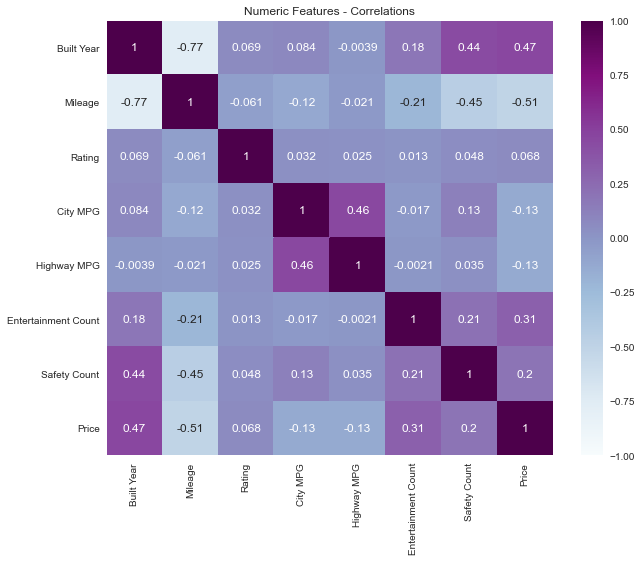

In [6]:
#corellations of numeric features
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(num_df.corr(),cmap="BuPu", annot=True, vmin=-1, vmax=1)
plt.title("Numeric Features - Correlations")

* Built year, Mileage and Entertainment Count have the highest corellations with the price!
* Looks life the Rating feature doesn't have much of a corellation with price so we might drop it later!
* City and Highway MPG are giving close corellations so we should combine them by taking their average!

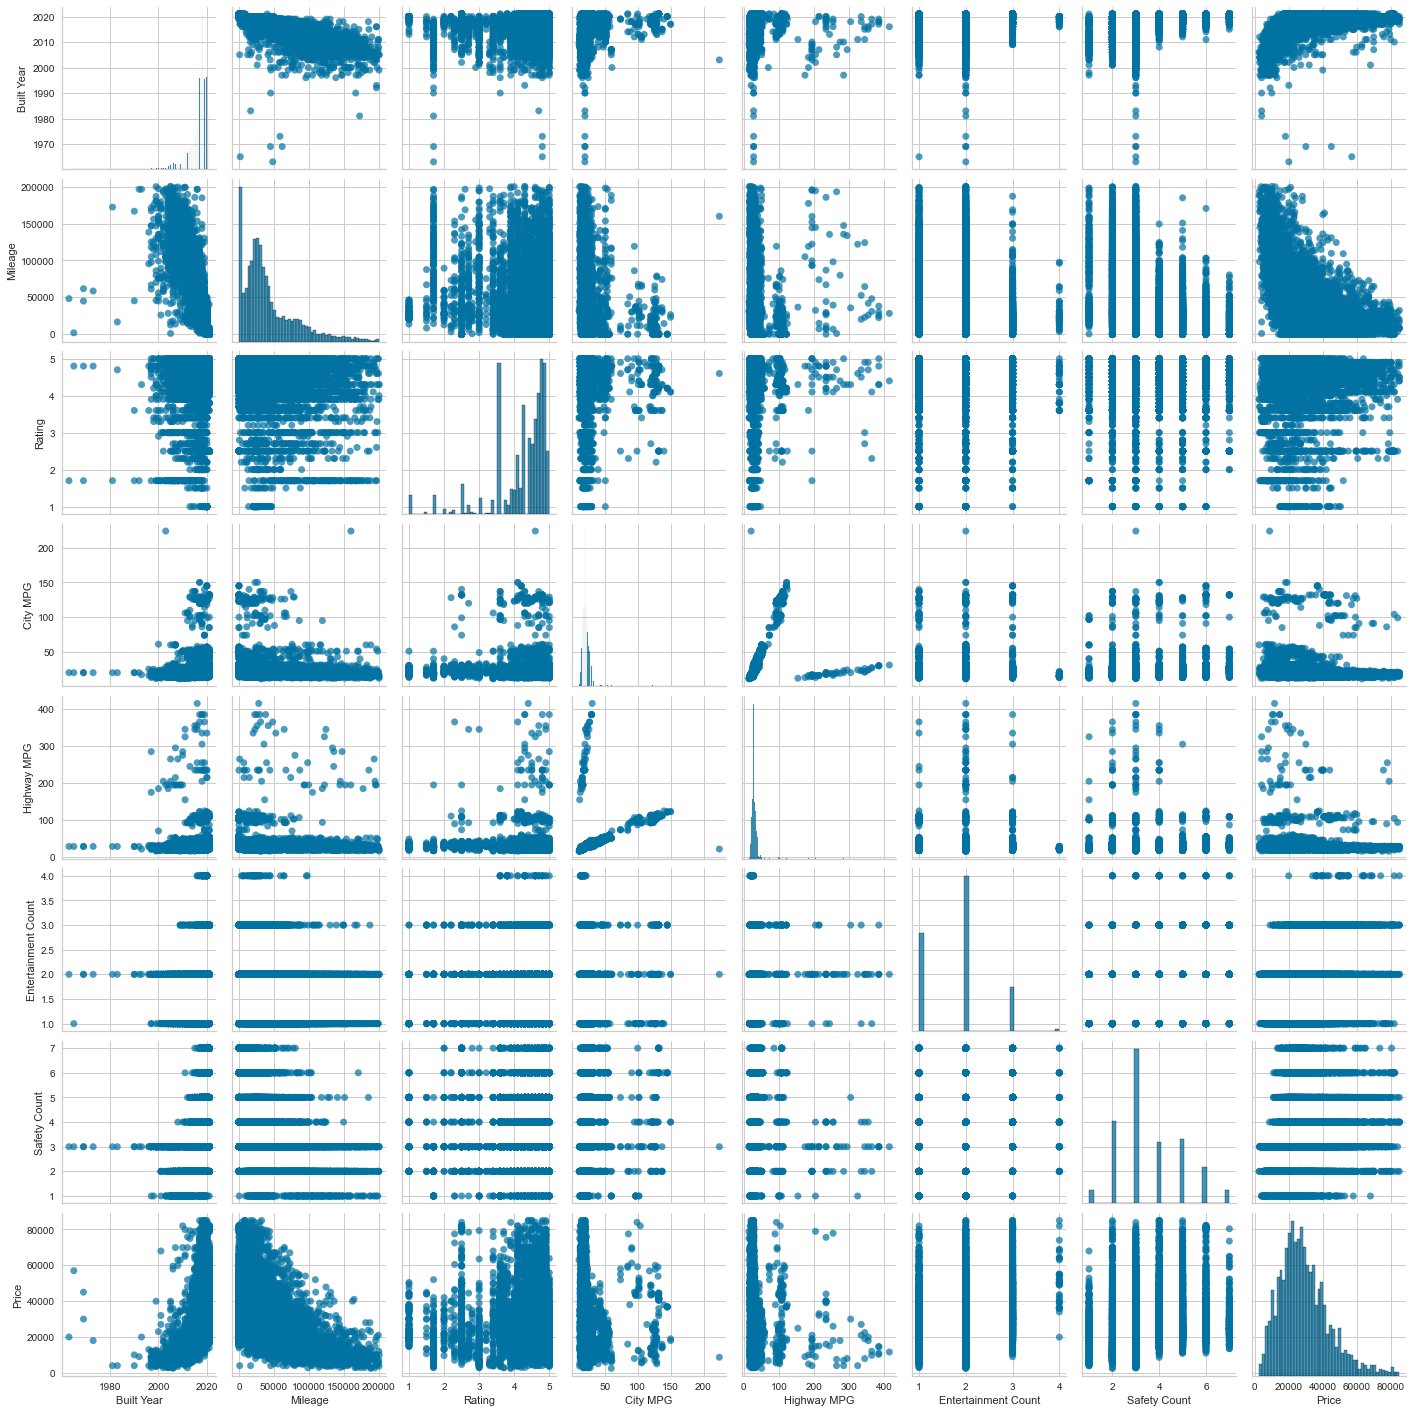

In [7]:
sns.pairplot(num_df, plot_kws=dict(alpha=.7, edgecolor='none'))

* Let's start with a simple regression model as our base by using our numerical features only!

[(0.0, 100000.0)]

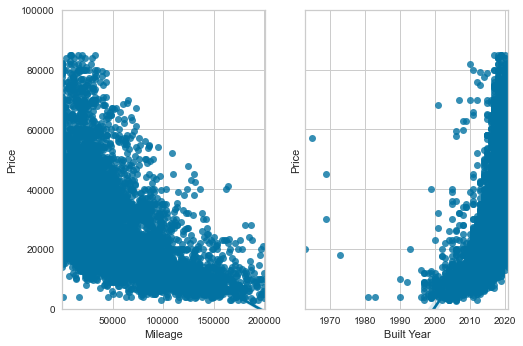

In [8]:
#taking a closer look into Mileage and Built Year
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x=num_df['Mileage'], y=num_df['Price'], ax=ax1)
sns.regplot(x=num_df['Built Year'], y=num_df['Price'], ax=ax2)
ax1.set(ylim=(0, 100000))

In [9]:
#the numeric predictors and target
X_num = num_df[['Built Year', 'Mileage', 'Rating', 'City MPG', 'Highway MPG',
                    'Entertainment Count', 'Safety Count']]
y_num = num_df['Price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, test_size=0.2, random_state=42)

#simple linear regression model
lm = LinearRegression()
model_fit = lm.fit(X_train,y_train)

#getting predictions
y_pred = model_fit.predict(X_test)

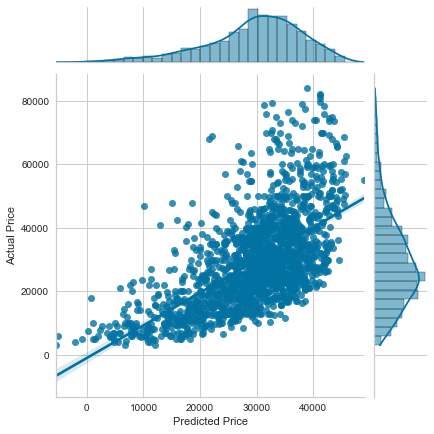

In [11]:
#ploting the actual vs predicted values 
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

In [12]:
print(f'Linear Regression R^2 score on train set: {model_fit.score(X_train, y_train):.4f}')
print(f'Linear Regression R^2 score on test set: {model_fit.score(X_test, y_test):.4f}')
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))

Linear Regression R^2 score on train set: 0.3523
Linear Regression R^2 score on test set: 0.3731
Mean Absolute Error: 8940.139775140977
Mean Squared Error: 133294905.24408776
Root Mean Square Error (RMSE): 11545.341278805394


Seems like we need to work on our features and improve our model!!

In [13]:
#going to create a column to average City-MPG and Highway-MPG
df['Avg MPG'] = df[['City MPG', 'Highway MPG']].mean(axis=1)

#dropping both City_MPG and Highway_MPG columns
df.drop(columns = ['City MPG', 'Highway MPG'], inplace = True)
print(df.shape)
df.head()

(8819, 16)


,Mileage,Rating,Fuel Type,Drivetrain,Engine,Exterior Color,Interior Color,Transmission,Entertainment Count,Safety Count,Price,Built Year,Make,Model,Zipcode,Avg MPG
0,37386,4.9,Gasoline,FWD,2.0L,Black,Unknown,Automatic,2.0,3.0,25800,2018,Volvo,V60,97214,30.5
1,22028,4.8,Gasoline,AWD,2.0L,White,Black,Automatic,3.0,4.0,38788,2019,Audi,A5,97201,28.5
2,86721,4.9,Gasoline,FWD,2.5L,White,Black,Automatic,2.0,2.0,8599,2009,Volkswagen,Other,97232,24.5
3,11936,3.6,Gasoline,FWD,Regular,Black,Unknown,Automatic,2.0,5.0,25799,2018,Toyota,Camry,97209,33.5
4,33065,4.3,Gasoline,4WD,4.6L,Gray,Brown,Automatic,2.0,3.0,39990,2018,Lexus,GX,97239,16.5


In [14]:
df.to_excel(r'C:\Users\nesha\Desktop\car_cleaned_data.xlsx')

In [15]:
#creating an interaction feature by dividing the mileage by built year
df['Mil_buil'] = df['Mileage']/df['Built Year']

#dropping Built Year and Mileage
df.drop(columns = ['Mileage', 'Built Year'], inplace = True)
df.shape

(8819, 15)

In [16]:
#now that we've added and dropped columns let's redefine a new numerical features df:
new_numeric_features = ['Mil_buil', 'Rating', 'Avg MPG',
                    'Entertainment Count', 'Safety Count', 'Price']
num_df2 = df.loc[:,new_numeric_features]
num_df2.head()

,Mil_buil,Rating,Avg MPG,Entertainment Count,Safety Count,Price
0,18.526264,4.9,30.5,2.0,3.0,25800
1,10.910352,4.8,28.5,3.0,4.0,38788
2,43.166252,4.9,24.5,2.0,2.0,8599
3,5.914767,3.6,33.5,2.0,5.0,25799
4,16.385035,4.3,16.5,2.0,3.0,39990


In [17]:
#the numeric predictors and target
X_num2 = num_df2[['Mil_buil', 'Rating', 'Avg MPG',
                    'Entertainment Count', 'Safety Count']]
y_num2 = num_df2['Price']

#calculating VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_num2.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_num2.values, i)
                          for i in range(len(X_num2.columns))]
  
print(vif_data)

               Feature        VIF
0             Mil_buil   2.283458
1               Rating  13.252779
2              Avg MPG   3.969278
3  Entertainment Count   7.546962
4         Safety Count   7.994094


In [18]:
#Dropping Rating column due to high VIF
df.drop(columns = ['Rating'], inplace = True)

In [19]:
#the numeric predictors and target
X_num3 = num_df2[['Mil_buil','Avg MPG',
                    'Entertainment Count', 'Safety Count']]
y_num3 = num_df2['Price']

#calculating VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_num3.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_num3.values, i)
                          for i in range(len(X_num3.columns))]
  
print(vif_data)

               Feature       VIF
0             Mil_buil  1.805435
1              Avg MPG  3.628254
2  Entertainment Count  6.165501
3         Safety Count  6.029562


In [20]:
new_numeric_features = ['Mil_buil','Avg MPG',
                    'Entertainment Count', 'Safety Count', 'Price']
num_df3 = df.loc[:,new_numeric_features]

Text(0.5, 1.0, 'New Numeric Features post VIF Evaluation - Correlations')

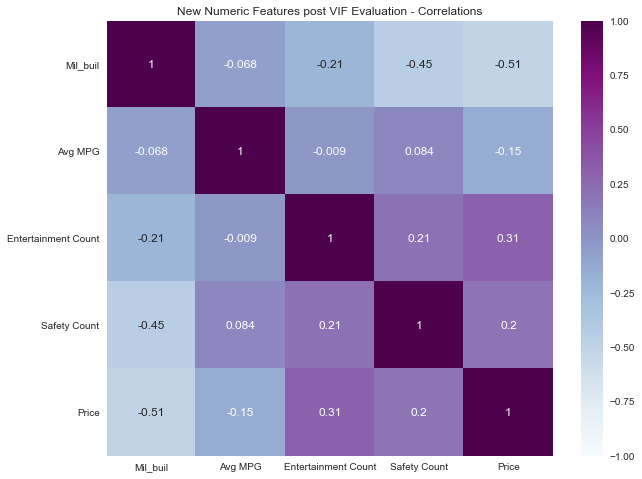

In [21]:
#corellations of numeric features
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(num_df3.corr(),cmap="BuPu", annot=True, vmin=-1, vmax=1)
plt.title("New Numeric Features post VIF Evaluation - Correlations")

In [22]:
#before going any further let's check the shape of the original data
df.shape

(8819, 14)

In [23]:
#the numeric predictors and target

X_train, X_test, y_train, y_test = train_test_split(X_num3, y_num3, test_size=0.2, random_state=42)

#simple linear regression model
lm = LinearRegression()
model_fit = lm.fit(X_train,y_train)

#getting predictions
y_pred = model_fit.predict(X_test)

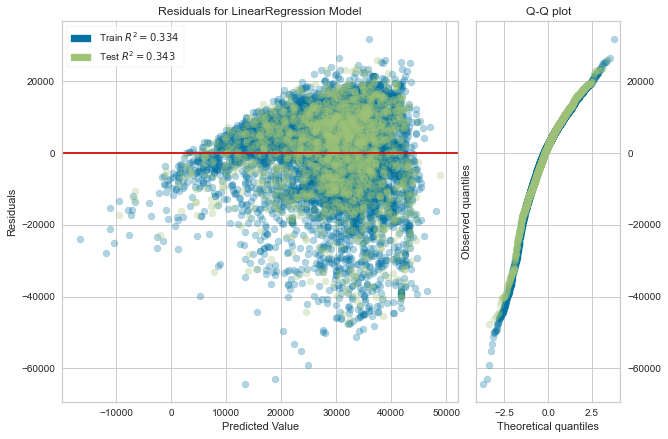


Residuals Plot


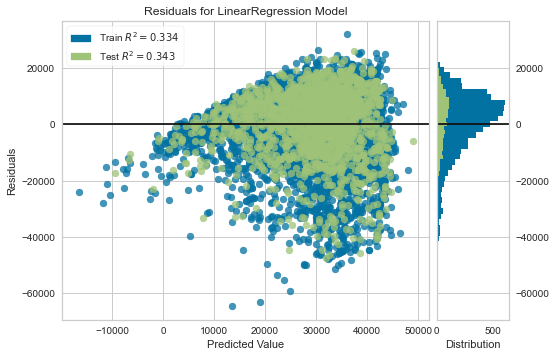

ResidualsPlot(ax=<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
              estimator=LinearRegression(), line_color=None, test_alpha=None,
              test_color=None, train_alpha=None, train_color=None)


In [24]:
# Making the Residuals Plot
plt.figure(figsize=(10,7))
res_plt = ResidualsPlot(model_fit, hist=False, qqplot=True, train_alpha=0.3, test_alpha=0.3, line_color='r')
res_plt.fit(X_train, y_train)  #fitting training data to the visualizer
res_plt.score(X_test, y_test)  #evaluating the model on the test data
res_plt.show();

print("\nResiduals Plot")
print(residuals_plot(model_fit, X_train, y_train, X_test, y_test))

In [25]:
log_y = np.log(y_num)
X_train, X_test, y_train, y_test = train_test_split(X_num3, log_y, test_size=0.2, random_state=42)
log_model = sm.OLS(y_train,X_train)
log_fit = log_model.fit()
log_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                          3.471e+04
Date:                Tue, 12 Oct 2021   Prob (F-statistic):                        0.00
Time:                        12:36:58   Log-Likelihood:                         -15682.
No. Observations:                7055   AIC:                                  3.137e+04
Df Residuals:                    7051   BIC:                                  3.140e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Mil_buil                0.0580      0.001     46.756      0.000       0.056       0.060
Avg MPG                 0.0448      0.002     27.642      0.000       0.042       0.048
Entertainment Count     1.9405      0.034     57.306      0.000       1.874       2.007
Safety Count            1.0329      0.017     60.875      0.000       1.000       1.066
==============================================================================
Omnibus:                      235.739   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.214
Skew:                          -0.419   Prob(JB):                     4.70e-60
Kurtosis:                       3.478   Cond. No.                         52.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Seems like log transforming the target helped with accuracy!

In [26]:
y_num4 = np.log(num_df2['Price'])

#creating a train\validation\test set (80/20/20)
X, X_test, y, y_test = train_test_split(X_num3, y_num4, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=41)

In [27]:
#model: simple Linear Model
lm = LinearRegression()
lm.fit(X_train,y_train)
print("R^2 of Train Set:", round(lm.score(X_train,y_train),4))
print("R^2 of Validation Set:", round(lm.score(X_val,y_val),4))
print("R^2 of Test Set:", round(lm.score(X_test,y_test),4))

R^2 of Train Set: 0.4592
R^2 of Validation Set: 0.477
R^2 of Test Set: 0.4525


Adding polynomialfeatures to see if we can improve the scores:

In [28]:
#polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)

print("R^2 of Train Set with Poly:", round(lr_poly.score(X_train_poly,y_train),4))  
print("R^2 of Validation Set with Poly:", round(lr_poly.score(X_val_poly, y_val),4))
print("R^2 of Test Set with Poly:", round(lr_poly.score(poly.transform(X_test), y_test),4))

R^2 of Train Set with Poly: 0.5472
R^2 of Validation Set with Poly: 0.5493
R^2 of Test Set with Poly: 0.5384


Thes scores improved but we need to add Categorical features so we might improve the scores!

In [29]:
#df.drop(columns = ['Zipcode'], inplace = True)

In [30]:
df.columns

Index(['Fuel Type', 'Drivetrain', 'Engine', 'Exterior Color', 'Interior Color',
       'Transmission', 'Entertainment Count', 'Safety Count', 'Price', 'Make',
       'Model', 'Zipcode', 'Avg MPG', 'Mil_buil'],
      dtype='object')

In [31]:
#Creating X and Y
cars_df = pd.get_dummies(df, drop_first=True)
print(cars_df.shape)
cars_df.head()

(8819, 434)


,Entertainment Count,Safety Count,Price,Avg MPG,Mil_buil,Fuel Type_ Diesel,Fuel Type_ E85 Flex Fuel,Fuel Type_ Electric,Fuel Type_ Gasoline,Fuel Type_ Hybrid,...,Zipcode_98682,Zipcode_98801,Zipcode_98841,Zipcode_98901,Zipcode_98902,Zipcode_98903,Zipcode_98926,Zipcode_98942,Zipcode_OR,Zipcode_WA
0,2.0,3.0,25800,30.5,18.526264,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,4.0,38788,28.5,10.910352,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,2.0,8599,24.5,43.166252,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,5.0,25799,33.5,5.914767,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,3.0,39990,16.5,16.385035,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
cars_x = cars_df.loc[:,cars_df.columns != 'Price']
cars_y =np.log(cars_df['Price'])

In [33]:
#creating a train\validation\test set (80/20/20)
X, X_test, y, y_test = train_test_split(cars_x, cars_y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43)

lm = LinearRegression()
lm.fit(X_train,y_train)

print("Linear R^2 of train set including all features:" ,lm.score(X_train,y_train))
print("Linear R^2 of validation set including all features:", lm.score(X_val, y_val))

Linear R^2 of train set including all features: 0.8890771902439968
Linear R^2 of validation set including all features: -5.728011617708897e+16


model is extremely overfitting! We need to use Regularization:

In [34]:
#scaling X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#fitting Lasso
lasso = LassoCV()
lasso.fit(X_train_scaled,y_train)

print("Lasso R^2 of train set including all features:", lasso.score(X_train_scaled,y_train))
print("Lasso R^2 of validation set including all features:", lasso.score(X_val_scaled, y_val))

Lasso R^2 of train set including all features: 0.886039338776283
Lasso R^2 of validation set including all features: 0.8548955456966625


In [35]:
list(zip(X_train.columns, lasso.coef_))

[('Entertainment Count', 0.029084084321892013),
 ('Safety Count', 0.039763484714727175),
 ('Avg MPG', -0.01790455074502021),
 ('Mil_buil', -0.30611812539740413),
 ('Fuel Type_ Diesel', 0.019567282150893206),
 ('Fuel Type_ E85 Flex Fuel', -0.000676304306278861),
 ('Fuel Type_ Electric', 0.0),
 ('Fuel Type_ Gasoline', -0.0),
 ('Fuel Type_ Hybrid', 0.014914846099169873),
 ('Fuel Type_ Unknown', -0.0009068946649411435),
 ('Drivetrain_4WD', 0.06316734100423585),
 ('Drivetrain_AWD', 0.0),
 ('Drivetrain_FWD', -0.08235714107064808),
 ('Drivetrain_Quattro', 7.477558431126296e-05),
 ('Drivetrain_RWD', -0.012470817818835125),
 ('Engine_1.2L', -0.0070709918960921965),
 ('Engine_1.3L', -0.0),
 ('Engine_1.4L', -0.012208715818104897),
 ('Engine_1.5L', -0.012217861671442646),
 ('Engine_1.6L', -0.0194969079912366),
 ('Engine_1.8L', -0.021549516679377375),
 ('Engine_2.', 0.012471700879327044),
 ('Engine_2.0L', -0.0004284753771673874),
 ('Engine_2.2L', -0.018309971381476237),
 ('Engine_2.3L', -0.00694205

In [36]:
#fitting Ridge
ridge = RidgeCV()
ridge.fit(X_train_scaled,y_train)

print("Ridge R^2 of train set including all features:", ridge.score(X_train_scaled,y_train))
print("Ridge R^2 of validation set including all features:", ridge.score(X_val_scaled, y_val))

Ridge R^2 of train set including all features: 0.8888174656493643
Ridge R^2 of validation set including all features: 0.8535610886741153


Seems like Lasso and Ridge scores are similar!

Let's try K-fold CV for validation:

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cars_x)

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(lasso, X_scaled, cars_y, cv=kf, scoring='r2')))

0.8652794620753724


Since the goal is to build an accurate model, let's try more complex models with high accuracies:

In [39]:
X_train, X_test, y_train, y_test = train_test_split(cars_x, cars_y, test_size=0.2,random_state=42)

#Gradient Boosting regressor
gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

print("Gradient Boosted Regression - Test set:", r2_score(y_test, y_pred))

Gradient Boosted Regression - Test set: 0.791560910728315


Prediction Error Plot for Gradient Boosting Regressor


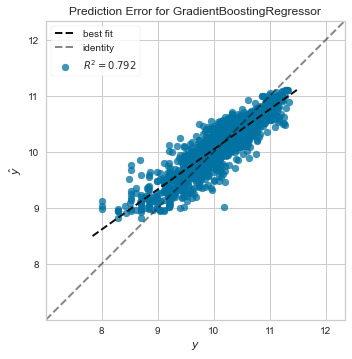

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for GradientBoostingRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                    n_estimators=500))


In [40]:
#prediction Error Plot
print("Prediction Error Plot for Gradient Boosting Regressor")
print(prediction_error(gbm, X_train, y_train, X_test, y_test))

In [41]:
# #Hyper-parameter tuning using Grid Search
# param_grid = {"criterion": ["mse", "mae"],
#               "max_depth": [2,5,10,25],
#               "n_estimators" : [100,200,800,1000]
#               }

# grid_cv_dtr = GridSearchCV(gbm, param_grid)

# grid_cv_dtr.fit(cars_x,cars_y)

# print("R-Squared::{}".format(grid_cv_dtr.best_score_))
# print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

In [42]:
def XGBoost_train_test(X, y):
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    print('R^2 for train set: {}'.format(r2_score(y_train, model.predict(X_train))))
    print('R^2 for val set: {}'.format(r2_score(y_val, model.predict(X_val))))
    print('R^2 for test set: {}'.format(r2_score(y_test, model.predict(X_test))))
    print('Mean Absolute Error: {}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_pred))))
    print('Mean Squared Error: {}'.format(mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('Root Mean Square Error (RMSE): {}'.format(math.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))))

In [43]:
XGBoost_train_test(cars_x, cars_y)

R^2 for train set: 0.9549376144311664
R^2 for val set: 0.8801333219710472
R^2 for test set: 0.8878736796983315
Mean Absolute Error: 3454.7050335596477
Mean Squared Error: 23973508.83415275
Root Mean Square Error (RMSE): 4896.2749957649185


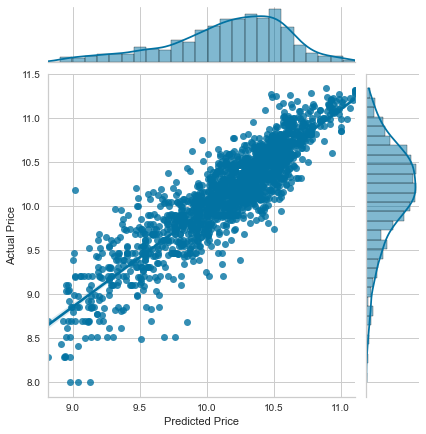

In [44]:
#plotting actual vs predicted values using XGBoost model
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

In [45]:
#now training the model on both train and validation set
cars_x = cars_df.loc[:,cars_df.columns != 'Price']
cars_y =np.log(cars_df['Price'])

X_train, X_test, y_train, y_test = train_test_split(cars_x, cars_y, test_size=0.2,random_state=42)
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

    
print('R^2 for train set: {}'.format(r2_score(y_train, model.predict(X_train))))
print('R^2 for val set: {}'.format(r2_score(y_val, model.predict(X_val))))
print('R^2 for test set: {}'.format(r2_score(y_test, model.predict(X_test))))
print('Mean Absolute Error: {}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_pred))))
print('Mean Squared Error: {}'.format(mean_squared_error(np.exp(y_test), np.exp(y_pred))))
print('Root Mean Square Error (RMSE): {}'.format(math.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))))

R^2 for train set: 0.9505113185881222
R^2 for val set: 0.9506012027236002
R^2 for test set: 0.8999858910226369
Mean Absolute Error: 3323.4882000081934
Mean Squared Error: 21927652.242360685
Root Mean Square Error (RMSE): 4682.69711196023


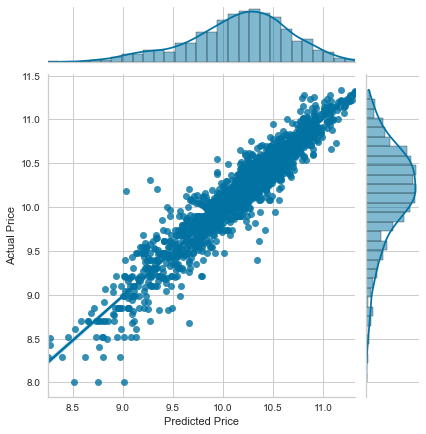

In [46]:
#plotting actual vs predicted values using XGBoost model
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

Prediction Error Plot for XGBoost Regressor


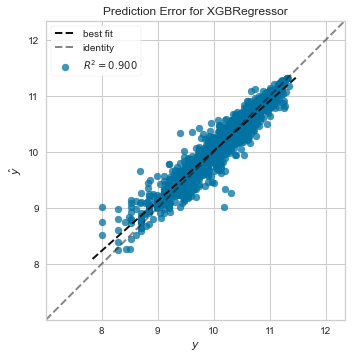

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=8,
                                       num_parallel_tree=1, random_state=0,
                                       reg_alpha=0, reg_lambda=1,
                                 

In [47]:
#prediction Error Plot
print("Prediction Error Plot for XGBoost Regressor")
print(prediction_error(model, X_train, y_train, X_test, y_test))

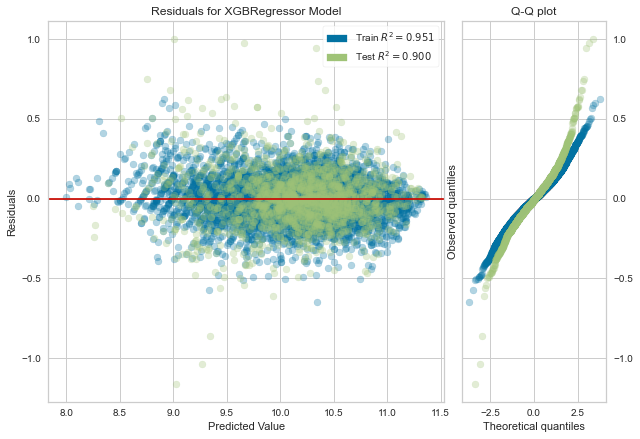


Residuals Plot


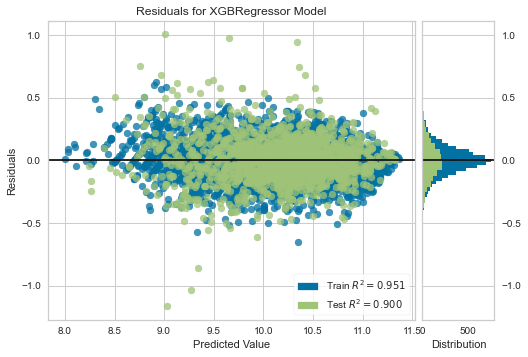

ResidualsPlot(ax=<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>,
              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_we

In [48]:
# Making the Residuals Plot
plt.figure(figsize=(10,7))
res_plt = ResidualsPlot(model, hist=False, qqplot=True, train_alpha=0.3, test_alpha=0.3, line_color='r')
res_plt.fit(X_train, y_train)  #fitting training data to the visualizer
res_plt.score(X_test, y_test)  #evaluating the model on the test data
res_plt.show();

print("\nResiduals Plot")
print(residuals_plot(model, X_train, y_train, X_test, y_test))